# Transriptomic coverage

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

import rnaseqTools

def sns_styleset():
    sns.set(context='paper', style='ticks', font='Arial')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.minor.width'] = .5
    matplotlib.rcParams['ytick.minor.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

with np.errstate(invalid='ignore'):
    layers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    layers[normdepth < 0.07] = '1'
    layers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    layers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers[normdepth > 0.73] = '6'

In [3]:
# Load ephys traces

with open('../data/processed/ephys/three_traces.pickle', 'rb') as f:
    three_traces = pickle.load(f)

In [4]:
# Find reconstruction

import os
swcfiles = {}
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/excitatory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/inhibitory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
        
print('Found {} .SWC files'.format(len(swcfiles)))
              
for i in np.where(m1.traced)[0]:
    if m1.cells[i] not in swcfiles:
        print('SWC not found: ' + m1.cells[i])
for c in swcfiles:
    if np.sum(m1.cells==c)==0:
        print('Not in the spreadsheet: ' + c + '\n' + swcfiles[c] + '')
    elif ~m1.traced[m1.cells==c]:
        print('Not marked as traced: ' + c)
        
swcfiles_vipdendrites = {}
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/vip_dendrites_only/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles_vipdendrites[filename[:-4]] = os.path.join(dirpath, filename)
        
print('Found {}  .SWC files for VIP dendrites'.format(len(swcfiles_vipdendrites)))

Found 646 .SWC files
Found 30  .SWC files for VIP dendrites


In [5]:
# Plot one neuron

def plot_swc(file_path, ax, offset=0, depth=500.0, thickness=1000.0,
             dendrite_color='r', axon_color='darkgreen', soma_color='k', 
             s=.05, minwidth=0, soma_s=3):
    
    swc = pd.read_csv(file_path, delim_whitespace=True, comment='#',
                      names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    
    dendrites = swc['type'] == 3
    axons = swc['type'] == 2
    soma = swc['type'] == 1
    
    swc['x'] = swc['x']/thickness
    swc['y'] = swc['y']/thickness
        
    soma_loc = swc.iloc[0][['x', 'y']]
    soma_loc['y'] = soma_loc['y'] + depth/thickness
    
    to_plot = np.zeros_like(dendrites)
    if dendrite_color!='none':
        to_plot |= dendrites
    if axon_color!='none':
        to_plot |= axons
    width = np.max(swc['x'][to_plot]) - np.min(swc['x'][to_plot])
    offset += np.abs(np.min(swc['x'][to_plot]-soma_loc['x']))
    if width < minwidth:
        offset += (minwidth-width)/2
        width = minwidth  
    soma_loc['x'] = soma_loc['x'] - offset
    
    if dendrite_color!='none':
        ax.scatter(swc['x'][dendrites]-soma_loc['x'], swc['y'][dendrites]-soma_loc['y'], 
                   s=s, c=dendrite_color, edgecolors='none', rasterized=True)
    if axon_color!='none':
        ax.scatter(swc['x'][axons]-soma_loc['x'], swc['y'][axons]-soma_loc['y'], 
                s=s, c=axon_color, edgecolors='none', rasterized=True)
    if soma_color!='none':
        ax.scatter(swc['x'][soma]-soma_loc['x'], swc['y'][soma]-soma_loc['y'], 
                s=s, c=soma_color, edgecolors='none', rasterized=True)
    else:
        ax.scatter(offset, -depth/thickness, s=soma_s, c='k', edgecolors='none')
        
    return width


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

## Figure 1: coverage

<IPython.core.display.Javascript object>


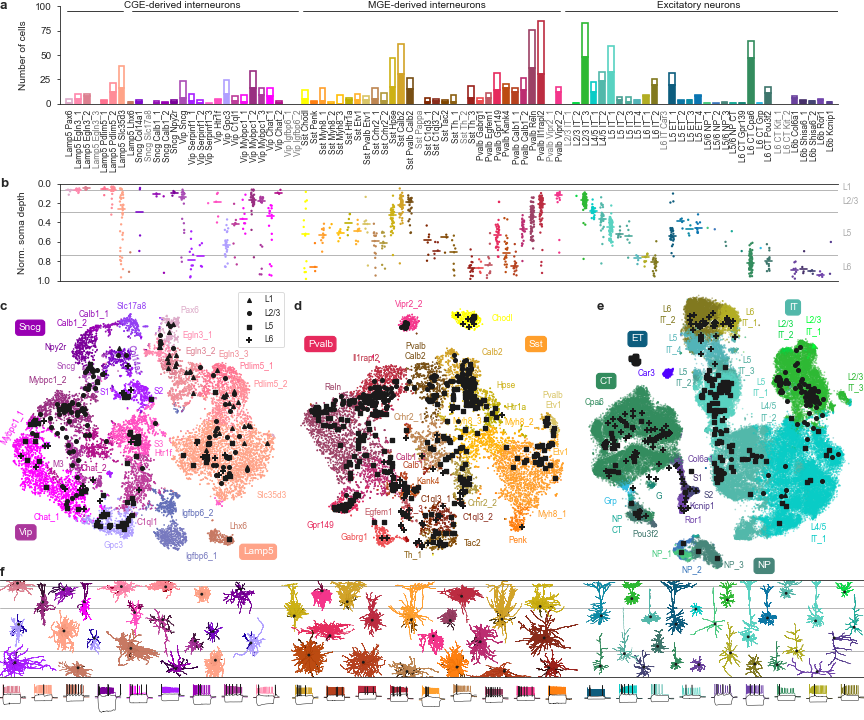

In [6]:
fig = plt.figure(figsize=(7.2, 6))
dz = .4
dw = .135
ax1 = plt.axes([.07,.856,.9,dw])
ax2 = plt.axes([.07,.2+.4+.01,.9,dw])
ax3 = plt.axes([0,.2,1.0/3,dz])
ax4 = plt.axes([1.0/3,.2,1.0/3,dz])
ax5 = plt.axes([2.0/3,.2,1.0/3,dz])
ax6 = plt.axes([0,.06,1,dw])
ax7 = plt.axes([0,0,1,.05])

In [7]:
plt.sca(ax7)

plt.xticks([])
plt.yticks([])
sns.despine(ax=ax7, left=True, bottom=True)
plt.xlim([0,30])
plt.ylim([-250,50])

neurons_to_show = [951, 1231, 573, 950, 863, 1217, 764, 1206, 1313, 
                   321, 778, 327, 387, 959, 886, 670, 640, 1036,
                   6, 1100, 316, 58, 666, 1272, 796, 687, 759]

for num,n in enumerate(neurons_to_show):
    i = n-1
    typ = ttypes['type'][i]
    col = clusterColors[clusterNames==typ][0]

    time = three_traces[m1.cells[i]][:,3]
    traces = three_traces[m1.cells[i]][:,:3]
    
    traces = traces[time<=.9,:]
    time   = time[time<=.9]
    
    t = time + num*1.1
    
    t += np.floor(num/9) * .25
        
    ax7.plot(t, traces[:,2], color=col, linewidth=.3, rasterized=True)
    ax7.plot(t, traces[:,1], color='k', linewidth=.3, rasterized=True)
    ax7.plot(t, traces[:,0], color='k', linewidth=.3, rasterized=True)

In [8]:
plt.sca(ax6)

plt.ylim([-1,0])
plt.xlim([0, 7.2/(6*.135)])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax6, left=True, top=False)
for y in [0.07,0.29,0.73]:
    plt.plot(plt.xlim(), [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
    
neurons_to_show = {951:  0,   # L1 Lamp5
                   1231: 0.5,   # L5 NGC
                   573:  1.1, # fat Lhx6 NGC
                   950:  2.3, # Sncg
                   863:  .8, # bipolar
                   1217: 0,  # L6 Serpinf
                   764:  1.65, # L6 Sncg,
                   1206: 1.9, # L5 Vip 
                   1313: 1.0,
                   988:  1.5,
                   940:  2.0,
                   893:  0.35,
                   1143: 0.6,
                   1123: .9,
                   1052: 0.1,
                   1193: 2.1,
                   1039: 1.5,
                   1079: 2.1,
                   1326: 0.5,
                   979:  2.4,
                   1214: 1.3,
                   
                   321:  3.4, # L2/3 MC
                   778:  3.5, # fat L6 Pvalb
                   327:  4.5,  # L2/3 BC
                   387:  3.7,   # L5 BC
                   959:  4, # T-shape MC
                   886:  4, # L6b Sst,
                   670:  4.5,  # shrub
                   640:  4.3, # deep chandelier
                   955:  3.2,
                   1036: 4.5,
                   681:  5.0,
                   1137: 4.8,
                   672:  2.9,
                   540:  5.3,
                   125:  3.0,
                   638:  4.8,
                   830:  3.0,
                   974:  5.4,
                   1022: 5.5,
                   
                   6:    6.8,  # L5 ET
                   1100: 7.1, # stellate in L4
                   316:  6.6, # untufted in upper L5
                   58:   7.6, # deep tufted
                   666:  7.1, #L6b small
                   1272: 8.1, # L6b wide
                   796:  7.9, # L6 CT
                   687:  7.4, # L6 IT
                   759:  7.67, # L6 IT small
                   391:  6.4, # L2/3
                   1201: 7.1, # NP,
                   167:  8.0, # L2/3 Rspo
                   118:  8.3, # big L5 IT
                   769:  8.5, # inverted in L5
                   1196: 8.05, # L6 IT high
                   13:   7.8, # smaller ET
                   1227: 8.7, # NP CT
                   115:  8.6, # L2/3 IT_2
                   1285: 6.0,
                   711:  6.1,
                   1106: 6.5,
                   1103: 6.3,
                   1099: 6.9,
                   741:  6.7,
                   186:  7.4,
                  }

for num,n in enumerate(neurons_to_show):
    i = n-1
    typ = ttypes['type'][i]
    col = clusterColors[clusterNames==typ][0]
    if np.isin(ttypes['family'][i], ['IT','ET','NP','CT']):
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
    
    plot_swc(swcfiles[m1.cells[i]], ax=ax6, 
             depth=m1.depth[i], thickness=m1.thickness[i], offset=neurons_to_show[n],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none')

In [9]:
plt.sca(ax1)

totalcounts = np.array([np.sum((ttypes['m1consensus_ass']==i)&(m1.exclude=='')) 
                        for i in range(clusterN)]).astype(float)
reconcounts = np.array([np.sum((ttypes['m1consensus_ass']==i)&(m1.exclude=='')&m1.traced) 
                        for i in range(clusterN)]).astype(float)
reconcounts[totalcounts==0] = np.nan
totalcounts[totalcounts==0] = np.nan
plt.bar(range(clusterN), totalcounts-reconcounts, edgecolor=clusterColors, 
        color='w', bottom=reconcounts, width=0.65, linewidth=1)
plt.bar(range(clusterN), reconcounts, color=clusterColors, 
        edgecolor=clusterColors, width=0.65, linewidth=1)
plt.xticks(np.arange(clusterN)+.2, clusterNames, rotation=90, fontsize=5)
for ticklabel in plt.gca().get_xticklabels():
    if np.isnan(totalcounts[clusterNames==ticklabel.get_text()]):
        ticklabel.set_color('#777777')
plt.gca().tick_params(axis='x', length=0)
plt.xlim([-1, clusterN])
plt.ylim([0, 100])
plt.ylabel('Number of cells')
plt.yticks([0,25,50,75,100])
sns.despine(ax=ax1)

h = 95
plt.plot([-.2,6.2], [h,h], linewidth=.5, color='k')
plt.plot([7.2,26.2], [h,h], linewidth=.5, color='k')
plt.text(13, h+3, 'CGE-derived interneurons', fontsize=6, color='k', ha='center')
plt.plot([26.8, 56.2], [h,h], linewidth=.5, color='k')
plt.text((56+26)/2, h+3, 'MGE-derived interneurons', fontsize=6, color='k', ha='center')
plt.plot([56.8, 88.2], [h,h], linewidth=.5, color='k')
plt.text((88+56)/2, h+3, 'Excitatory neurons', fontsize=6, color='k', ha='center')

print('{:.0f} total cells in panel a'.format(np.nansum(totalcounts)))

1227 total cells in panel a


In [10]:
plt.sca(ax2)

confidenceCutoff = 0
ttypes['confidence'][np.isnan(ttypes['confidence'])] = -1

np.random.seed(42)
for t in range(clusterN):
    ind = (ttypes['m1consensus_ass']==t) & (m1.exclude=='') & ~np.isnan(m1.depth) & ~np.isnan(m1.thickness) & \
          (ttypes['confidence'] >= confidenceCutoff)
    d = m1.depth[ind] / m1.thickness[ind]
    if d.size > 0:
        plt.scatter(t + np.random.uniform(-1,+1,size=d.size)/5, d, 
                    color=clusterColors[t], s=2, edgecolor='none')
    if d.size >= 3:
        plt.plot(t + np.array([-.4,.4]), np.array([1,1]) * np.median(d),
                 color=clusterColors[t], linewidth=1)
plt.xticks([])
plt.xlim([-1, clusterN])
plt.ylabel('Norm. soma depth', labelpad=6)
plt.ylim([0,1])
plt.yticks(np.arange(0,1.01,.2))

ind = ~np.isnan(ttypes['m1consensus_ass']) & (m1.exclude=='') & ~np.isnan(m1.depth) & ~np.isnan(m1.thickness) & \
      (ttypes['confidence'] >= confidenceCutoff)
print('{} total cells in panel b'.format(np.sum(ind)))

for b in np.array([0.07, 0.29, 0.73]):
    plt.plot([-1, clusterNames.size], [b,b], linewidth=.5, color='#aaaaaa', zorder=0)
for L,b in zip(['L1','L2/3','L5','L6'], [0.07/2, (0.29+0.07)/2, (0.29+0.73)/2, 1.73/2]):
    plt.text(clusterN+.5,b,L, color='#aaaaaa', fontsize=5, va='center')

plt.gca().invert_yaxis()
sns.despine(ax=ax2, top=False)

1187 total cells in panel b


In [11]:
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))

shapes = {'1': '^', '2/3': 'o', '5': 's', '6': '+'}
sizes  = {'1': 5,   '2/3': 5,   '5': 4,   '6': 15}

In [12]:
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'rb'))
subset = np.isin(ttypes['family'], ['Lamp5', 'Vip'])
pos = rnaseqTools.map_to_tsne(m1data['viplamp']['counts'], m1data['viplamp']['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)
                              
plt.sca(ax3)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1, rasterized=True, edgecolors='none',
            c = clusterColors[m1data['viplamp']['clusters']])

sc = []
for L in ['1', '2/3', '5', '6']:
    s = plt.scatter(pos[layers[subset]==L,0], pos[layers[subset]==L,1], 
                    s=sizes[L], c='k', zorder=2, marker=shapes[L])
    sc.append(s)
    
leg = plt.legend(sc, ['L1','L2/3','L5','L6'], fontsize=5, loc='upper right')
leg.get_frame().set_linewidth(.5)

offsets = {'Lamp5 Slc35d3': [25,-20], 'Lamp5 Lhx6': [10,6], 'Lamp5 Pdlim5_2': [20,10],
           'Lamp5 Pdlim5_1': [20,5], 'Lamp5 Pax6': [10,8], 'Lamp5 Egln3_1': [20,8],
           'Lamp5 Egln3_2': [15,7], 'Lamp5 Egln3_3': [25,16], 'Vip Igfbp6_1': [15,-10],
           'Vip Igfbp6_2': [15,-5], 'Vip C1ql1': [5,-20], 'Vip Gpc3': [0,-12],
           'Vip Chat_1': [0,-17], 'Vip Mybpc1_2': [-10,15], 'Vip Mybpc1_1': [-8,5],
           'Sncg Slc17a8': [0,9], 'Sncg Calb1_1': [-8,7], 'Sncg Calb1_2': [-12,3],
           'Sncg Npy2r': [-15,0], 'Vip Sncg': [-12,5], 'Sncg Col14a1': [7,0],
           'Vip Htr1f': [15,-9], 'Vip Serpinf1_3': [2,-10], 'Vip Serpinf1_1': [-4,3],
           'Vip Mybpc1_3': [-10,0], 'Vip Serpinf1_2': [10,0], 'Vip Chat_2': [0,-10]}

angles = {'Vip Mybpc1_1': 60, 'Sncg Col14a1': -75}
renames = {'Vip Mybpc1_3': 'M3', 'Vip Serpinf1_1': 'S1', 'Vip Serpinf1_2': 'S2', 'Vip Serpinf1_3': 'S3'}

for c in np.unique(m1data['viplamp']['clusters']):
    ind = m1data['viplamp']['clusters']==c
    col = clusterColors[c]
    x,y = np.median(Z[ind,0]), np.median(Z[ind,1])
    if clusterNames[c] in offsets:
        x += offsets[clusterNames[c]][0]
        y += offsets[clusterNames[c]][1]
    if clusterNames[c] not in renames:
        label = '\n'.join(clusterNames[c].split()[1:])
    else:
        label = renames[clusterNames[c]]
    if clusterNames[c] not in angles:
        alpha = 0
    else:
        alpha = angles[clusterNames[c]]
        
    if ~np.isnan(x):
        plt.text(x, y, label, color=col, fontsize=5, ha='center', va='center', zorder=1, rotation=alpha)

col = clusterColors[clusterNames=='Vip Mybpc1_3'][0]
plt.text(-65, -50, 'Vip', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='Sncg Calb1_2'][0]
plt.text(-65, 55, 'Sncg', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='Lamp5 Slc35d3'][0]
plt.text(50, -60, 'Lamp5', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))

plt.xticks([])
plt.yticks([])
sns.despine(ax=ax3, left=True, bottom=True)

Using a common set of 490 genes.


In [13]:
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-pvsst.pickle', 'rb'))
subset = np.isin(ttypes['family'], ['Pvalb', 'Sst'])
pos = rnaseqTools.map_to_tsne(m1data['pvsst']['counts'], m1data['pvsst']['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

plt.sca(ax4)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1, rasterized=True, edgecolors='none',
            c = clusterColors[m1data['pvsst']['clusters']])

offsets = {'Sst Chodl': [18,0], 'Pvalb Vipr2_2': [0,10], 'Pvalb Vipr2_1': [np.nan, np.nan],
           'Sst Calb2': [17,10], 'Sst Hpse': [17,8], 'Sst Htr1a': [12,5],
           'Sst Pvalb Etv1': [0,12], 'Sst Etv1': [5,-5], 'Sst Myh8_1': [15,-22],
           'Sst Penk': [0,-10], 'Sst Pvalb Calb2': [-7,17], 'Pvalb Il1rapl2': [-8,15],
           'Pvalb Reln': [-5,24], 'Pvalb Gpr149': [-12,-10], 'Pvalb Gabrg1': [-15,0],
           'Pvalb Egfem1': [-15,0], 'Sst Myh8_2': [15,10], 'Sst Myh8_3': [0,13],
           'Sst Crhr2_1': [-12,14], 'Sst Crhr2_2': [10,-12], 'Pvalb Calb1_1':[8,7],
           'Pvalb Calb1_2': [19,12], 'Pvalb Kank4': [9,5], 'Sst Th_2': [np.nan, np.nan],
           'Sst Th_1': [-12,-7], 'Sst Tac2': [10,-4], 'Sst C1ql3_2': [17,0],
           'Sst C1ql3_1': [3,10], 'Sst Th_3': [-5,-2]}

for c in np.unique(m1data['pvsst']['clusters']):
    ind = m1data['pvsst']['clusters']==c
    col = clusterColors[c]
    x,y = np.median(Z[ind,0]), np.median(Z[ind,1])
    if clusterNames[c] in offsets:
        x += offsets[clusterNames[c]][0]
        y += offsets[clusterNames[c]][1]
    label = '\n'.join(clusterNames[c].split()[1:])
    
    if ~np.isnan(x):
        plt.text(x, y, label, color=col, fontsize=5, ha='center', va='center', zorder=1)

sc = []
for L in ['1', '2/3', '5', '6']:
    s = plt.scatter(pos[layers[subset]==L,0], pos[layers[subset]==L,1], 
                    s=sizes[L], c='k', zorder=2, marker=shapes[L])
    sc.append(s)
    
col = clusterColors[clusterNames=='Pvalb Gpr149'][0]
plt.text(-65, 50, 'Pvalb', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='Sst Myh8_1'][0]
plt.text(50, 50, 'Sst', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))

plt.xticks([])
plt.yticks([])
sns.despine(ax=ax4, left=True, bottom=True)

Using a common set of 493 genes.


In [14]:
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-exc.pickle', 'rb'))

plt.sca(ax5)
plt.gca().set_aspect('equal', adjustable='datalim')
np.random.seed(42)
order = np.random.permutation(Z.shape[0]) # to prevent one cluster obstructing another
plt.scatter(Z[order,0], Z[order,1], s=1, alpha=.5, rasterized=True, edgecolors='none',
            c = clusterColors[m1data['exc']['clusters']][order])

subset = np.isin(ttypes['family'], ['IT', 'CT', 'NP', 'ET'])
pos = rnaseqTools.map_to_tsne(m1data['exc']['counts'], m1data['exc']['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)
sc = []
for L in ['1', '2/3', '5', '6']:
    s = plt.scatter(pos[layers[subset]==L,0], pos[layers[subset]==L,1], 
                    s=sizes[L], c='k', zorder=2, marker=shapes[L])
    sc.append(s)
        
col = clusterColors[clusterNames=='L5 ET_1'][0]
plt.text(-45, 45, 'ET', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='L5/6 NP_3'][0]
plt.text(15, -63, 'NP', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='L6 CT Cpa6'][0]
plt.text(-60, 25, 'CT', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='L4/5 IT_2'][0]
plt.text(30, 60, 'IT', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))

offsets = {'L5 ET_1':[np.nan, np.nan], 'L5 ET_2':[np.nan, np.nan], 'L5 ET_3':[np.nan, np.nan],
           'L5 ET_4':[np.nan, np.nan], 'L5/6 NP_1':[-10,0], 'L5/6 NP_2':[5,-12], 'L5/6 NP_3':[12,-5],
           'L2/3 IT_1':[0,10], 'L2/3 IT_2': [0,10], 'L2/3 IT_3':[25,0], 'L6 IT Car3': [-10,0],
           'L4/5 IT_1': [10,-27], 'L4/5 IT_2': [12,27], 'L6 IT_1':[10,0], 'L6 IT_2': [-16,0],
           'L5 IT_4': [-15,2], 'L5 IT_3': [12,0], 'L5 IT_2': [-6,0], 'L5 IT_1': [20,5],
           'L6 CT Cpa6': [-20,15], 'L6 CT Grp': [-7,-7], 'L5/6 NP CT': [-7, -12], 'L6 CT Pou3f2': [5,-10],
           'L6 CT Kit_1': [np.nan, np.nan], 'L6 CT Kit_2': [np.nan, np.nan], 'L6 CT Gpr139': [3,-5],
           'L6b Col6a1': [10,3], 'L6b Shisa6_1': [7,2], 'L6b Shisa6_2': [7,-2], 'L6b Ror1': [5,-8],
           'L6b Kcnip1': [5,-17]}
renames = {'L6 CT Gpr139': 'G', 'L6b Shisa6_1': 'S1', 'L6b Shisa6_2': 'S2'}

for c in np.unique(m1data['exc']['clusters']):
    ind = m1data['exc']['clusters']==c
    col = clusterColors[c]
    x,y = np.median(Z[ind,0]), np.median(Z[ind,1])
    if clusterNames[c] in offsets:
        x += offsets[clusterNames[c]][0]
        y += offsets[clusterNames[c]][1]
    if clusterNames[c] not in renames:
        syllables = clusterNames[c].split()
        if syllables[-1][:-1]=='IT_':
            label = '\n'.join(syllables)
        elif np.isin(syllables[1], ['IT', 'CT']):
            label = '\n'.join(syllables[2:])
        else:
            label = '\n'.join(syllables[1:])
    else:
        label = renames[clusterNames[c]]
        
    if ~np.isnan(x):
        plt.text(x, y, label, color=col, fontsize=5, ha='center', va='center', zorder=1)
    
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax5, left=True, bottom=True)

Using a common set of 478 genes.


In [15]:
fig.text(.00, 1.0, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(.00, .74, 'b', fontsize=8, fontweight='bold')
fig.text(.00, .57, 'c', fontsize=8, fontweight='bold')
fig.text(.34, .57, 'd', fontsize=8, fontweight='bold')
fig.text(.69, .57, 'e', fontsize=8, fontweight='bold')
fig.text(.00, .20, 'f', fontsize=8, fontweight='bold')

plt.savefig('../figures/mainfigures/coverage.png', dpi=300)
plt.savefig('../figures/mainfigures/pdf/coverage_dpi300.pdf', dpi=300)
plt.savefig('../figures/mainfigures/pdf/coverage_dpi600.pdf', dpi=600)

## Full t-SNE

(121423, 2)


<IPython.core.display.Javascript object>


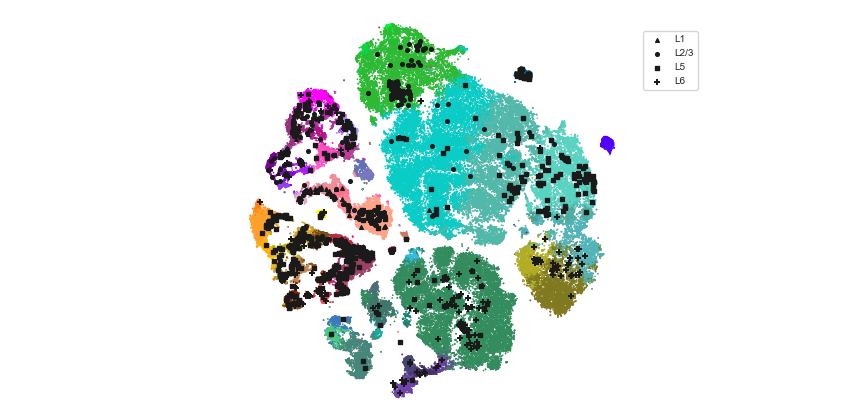

Using a common set of 965 genes.
Processing in batches.. done


In [16]:
shapes = {'1': '^', '2/3': 'o', '5': 's', '6': '+'}
sizes  = {'1': 5,   '2/3': 5,   '5': 4,   '6': 15}

m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-big.pickle', 'rb'))

print(Z.shape)

fig = plt.figure(figsize=(7.2, 3.5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1,
            c = clusterColors[m1data['neurons']['clusters']], edgecolor='none',
            rasterized=True)
plt.ylim([-100,100])
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('../figures/extra/tsne1.png', dpi=300)

pos = rnaseqTools.map_to_tsne(m1data['neurons']['counts'],
                              m1data['neurons']['genes'],
                              m1.exonCounts[ttypes['qc']=='good',:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[ttypes['qc']=='good',:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)
sc = []    
for L in ['1', '2/3', '5', '6']:
    s = plt.scatter(pos[layers[ttypes['qc']=='good']==L,0], 
                    pos[layers[ttypes['qc']=='good']==L,1], 
                    s=sizes[L], c='k', zorder=2, marker=shapes[L])
    sc.append(s)
plt.legend(sc, ['L1','L2/3','L5','L6'], loc=(.75,.8))

plt.savefig('../figures/extra/tsne2.png', dpi=300)